In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as MT
import matplotlib.lines as L
import matplotlib.cm as CM
import matplotlib.colors as C
import matplotlib.patches as PA
from mpl_toolkits.mplot3d import Axes3D

# make nice fonts for figures
font = {'size'   : 12}
matplotlib.rc('font', **font)
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
matplotlib.rc('text', usetex=True)

# whether or not to save figures
savefigs = False

# Load Results

In [2]:
# load the results from the simulations
df = pd.read_csv('results.csv')
df.head()

,Unnamed: 0,dm,dx,dy,imx,imy,imxy,uix,uiy,ri,si,flag,nuix,nuiy,nri,nsi
0,0,4,7,7,2.262387,1.687167,5.813904,0.784318,0.209098,1.478069,3.342419,NaN,0.134904,0.035965,0.254230,0.574901
1,1,4,10,10,1.624233,1.178019,7.986472,0.657036,0.210822,0.967197,6.151417,NaN,0.082269,0.026397,0.121104,0.770230
2,2,8,9,10,1.775975,2.620098,8.579433,0.414417,1.258540,1.361558,5.544918,NaN,0.048304,0.146693,0.158700,0.646304
3,3,9,10,10,2.593799,2.904314,10.545907,0.986923,1.297438,1.606876,6.654670,NaN,0.093584,0.123028,0.152370,0.631019
4,4,3,6,6,1.752101,0.667744,4.329965,1.172311,0.087954,0.579790,2.489910,NaN,0.270744,0.020313,0.133902,0.575042


# Box Plots

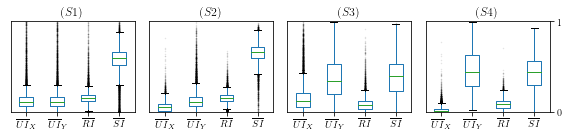

In [3]:
fig, axarr = plt.subplots(1,4,figsize=(8,2))
# get samples for condition 1
S1 = df.loc[(df['dm'] == df['dx']) & (df['dm'] == df['dy'])]
# get samples for condition 2
S2 = df.loc[(df['dm'] < df['dx']) & (df['dm'] < df['dy']) ]
# get samples for condition 3
S3 = df.loc[(df['dm'] > df['dx']) & (df['dm'] > df['dy']) ]
# get samples for condition 4
S4 = df.loc[((df['dm'] < df['dx']) & (df['dm'] > df['dy'])) | ((df['dm'] > df['dx']) & (df['dm'] < df['dy'])) ]

# make the outliers transparent
flierprops = dict(marker='.', markerfacecolor='k', markersize=1,
                  linestyle='none', markeredgecolor='k',alpha=0.1)
 
# make a boxplot for each of the sampling conditions
for i,(ax,s) in enumerate(zip(axarr.flatten(),[S1,S2,S3,S4])):
    bp = s.boxplot(column=['nuix','nuiy','nri','nsi'],ax=ax,flierprops=flierprops)
    ax.set_xticklabels([r'$\overline{UI}_X$',r'$\overline{UI}_Y$',r'$\overline{RI}$',r'$\overline{SI}$'])
    ax.set_title(r'$(S%i)$'%(i+1))
    ax.grid(False)
    ax.set_ylim([0,1])
    if i == 3:
        ax.yaxis.tick_right()
        ax.set_yticks([0,1])
    else:
        ax.set_yticks([])

plt.tight_layout()
if savefigs: plt.savefig('boxplot.png',dpi=500)

# Define Simplex Plotting Functions

In [4]:
# This code was adapted from https://gist.github.com/davidandrzej/939840 (Thanks, David!)

def plotSimplex(points,colors,titles,**kwargs):
    """
    Scatter points on a 2-dimensional 3-simplex with a 3rd dimension indicated by color
    
    kwargs will be passed along directly to matplotlib.pyplot.scatter    
    Returns Figure, caller must .show()
    """
    
    # offsets for different conditions
    xoff = 1.2
    yoff = 0
    fig = plt.figure(figsize=(9,2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    for i,(point,color,title) in enumerate(zip(points,colors,titles)):
        # Draw the triangle
        l1 = L.Line2D([0+(i*xoff), 0.5+(i*xoff), 1+(i*xoff), 0+(i*xoff)], # xcoords
                      [0+(i*yoff), np.sqrt(3) / 2+(i*yoff), 0+(i*yoff), 0+(i*yoff)], # ycoords
                      color='k')
        fig.gca().add_line(l1)
        fig.gca().xaxis.set_major_locator(MT.NullLocator())
        fig.gca().yaxis.set_major_locator(MT.NullLocator())
        # Draw vertex labels
        fig.gca().text(0+(i*xoff), -0.18+(i*yoff), r'$\overline{UI}_X$')
        fig.gca().text(0.86+(i*xoff), -0.18+(i*yoff), r'$\overline{UI}_Y$')
        fig.gca().text(0.43+(i*xoff), np.sqrt(3) / 2 + 0.05+(i*yoff), r'$\overline{RI}$')
        fig.gca().text(0.04+(i*xoff), np.sqrt(3) / 2 -0.2 +(i*yoff),title)
        # Project and draw the actual points
        projected = projectSimplex(point)
        plt.scatter(projected[:,0]+(i*xoff), projected[:,1]+(i*yoff),c=color, **kwargs)              

    cbar = plt.colorbar(ticks=[0,1])
    cbar.set_label(r'$\overline{SI}$',rotation=0)
    plt.clim([0,1])
    return fig    

def plotSimplex3D(ax,base_points,heights,angle=0,**kwargs):
    """
    Scatter points on a 3-dimensional 4-simplex 
    
    kwargs will be passed along directly to matplotlib.pyplot.scatter    
    Returns Figure, caller must .show()
    """

    fig.gca().xaxis.set_major_locator(MT.NullLocator())
    fig.gca().yaxis.set_major_locator(MT.NullLocator())
    # Draw vertex labels (added in photoshop... rotating makes things wonky)
    #fig.gca().text(0, -0.01,0, r'$\overline{UI}_X$',fontsize=10)
    #fig.gca().text(0.86, -0.01,0, r'$\overline{UI}_Y$',fontsize=10)
    #fig.gca().text(0.43, np.sqrt(3) / 2 + 0.2,0, r'$\overline{RI}$',fontsize=10)
    #fig.gca().text(0.43, 1 / (2*np.sqrt(3)) + 0.1,np.sqrt(3) / 2+ 0.2, r'$\overline{SI}$',fontsize=10)
    # Project and draw the actual points
    projected = projectSimplex(base_points)
    # Draw the pyramid
    ax.plot([0, 0.5, 1, 0], # xcoords
                  [0, np.sqrt(3) / 2, 0, 0], # ycoords
                  [0, 0, 0, 0], # zcoords
                  color='k',zorder=10)
    ax.plot([0, 0.5, 1, 0], # xcoords
                  [0, 1 / (2 * np.sqrt(3)) , 0, 0], # ycoords
                  [0, 1, 0, 0], # zcoords
                  color='k',zorder=10)
    ax.plot([1, 0.5, 0.5, 1], # xcoords
                  [0, 1 / (2 * np.sqrt(3)) , np.sqrt(3) / 2, 0], # ycoords
                  [0, 1, 0, 0], # zcoords
                  color='k',zorder=10)

    # plot the points
    ax.scatter(projected[:,0], projected[:,1],heights,c=heights, zorder=-1,**kwargs)

    # get rid of numbers
    ax.set_zticks([])
    
    # rotate
    ax.view_init(30, angle)


def projectSimplex(points):
    """ 
    Project probabilities on the 3-simplex to a 2D triangle
    
    N points are given as N x 3 array
    """
    # Convert points one at a time
    tripts = np.zeros((points.shape[0],2))
    for idx in range(points.shape[0]):
        # Init to triangle centroid
        x = 1.0 / 2
        y = 1.0 / (2 * np.sqrt(3))
        # Vector 1 - bisect out of lower left vertex 
        p1 = points[idx, 0]
        x = x - (1.0 / np.sqrt(3)) * p1 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p1 * np.sin(np.pi / 6)
        # Vector 2 - bisect out of lower right vertex  
        p2 = points[idx, 1]  
        x = x + (1.0 / np.sqrt(3)) * p2 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p2 * np.sin(np.pi / 6)        
        # Vector 3 - bisect out of top vertex
        p3 = points[idx, 2]
        y = y + (1.0 / np.sqrt(3) * p3)
      
        tripts[idx,:] = (x,y)

    return tripts

# Plot Results

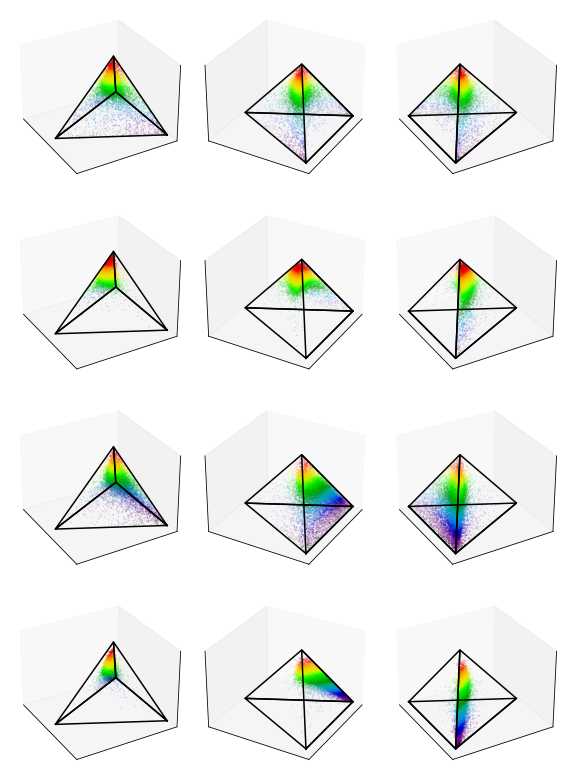

In [5]:
fig = plt.figure(figsize=(8,11))

# make the red points appear on top in 2d plot
df = df.sort_values(['nsi'])
# get samples for condition 1
S1 = df.loc[(df['dm'] == df['dx']) & (df['dm'] == df['dy'])]
# get samples for condition 2
S2 = df.loc[(df['dm'] < df['dx']) & (df['dm'] < df['dy']) ]
# get samples for condition 3
S3 = df.loc[(df['dm'] > df['dx']) & (df['dm'] > df['dy']) ]
# get samples for condition 4
S4 = df.loc[((df['dm'] < df['dx']) & (df['dm'] > df['dy'])) | ((df['dm'] > df['dx']) & (df['dm'] < df['dy'])) ]

# define colormap
cmap = CM.get_cmap('nipy_spectral')

# list of angles for different rotated views
angles = [150,210,330]

for i,dfs in enumerate([S1,S2,S3,S4]):
    base_points = np.vstack((dfs['nuix'].values,dfs['nuiy'].values,dfs['nri'].values)).T
    heights = dfs['nsi'].values
    for j,angle in enumerate(angles):
        ax = fig.add_subplot(4, 3, 3*i+j+1, projection='3d')
        plotSimplex3D(ax,base_points,heights,s=0.01,cmap=cmap,angle=angle)

plt.tight_layout()
# save figure
if savefigs: plt.savefig('3d_simplex.png',dpi=500)

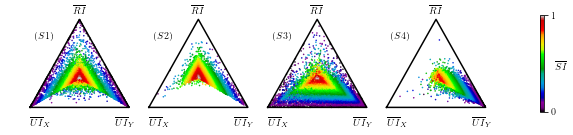

In [6]:
# store the positions and colors for each condition
points = []
colors = []
for dfs in [S1,S2,S3,S4]:
    points.append(np.vstack((dfs['nuix'].values,dfs['nuiy'].values,dfs['nri'].values)).T)
    colors.append(dfs['nsi'].values)

# titles for panels
titles = [r'$(S1)$',r'$(S2)$',r'$(S3)$',r'$(S4)$']

# do scatter plot
fig = plotSimplex(points,colors,titles,s=0.3,cmap=cmap)

plt.tight_layout()
# save figure
if savefigs: plt.savefig('2d_simplex.png',dpi=500)